In [2]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import networkx as nx
from numpy import linalg as LA
from scipy.special import comb
import itertools
import math
def sample_spherical(npoints, ndim):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec
def harmonic_eigespcDim(d,l):
    return comb(l+d-1,l)-comb(l+d-3,l-2)
def harmonic_eigespc(d,maxim):
    L=range(0,maxim)
    return [int(harmonic_eigespcDim(d,l)) for l in L]
def harmonic_eigespc2(d,deg):
    return [int(harmonic_eigespcDim(d,l)) for l in deg]
def estimator_Gram(arrayEigvec,dimEigspc,firsteig):
    rr=np.zeros((len(arrayEigvec[:,0]),len(arrayEigvec[:,0])))
    for i in range(firsteig,dimEigspc+firsteig-1):
        rr=rr+np.outer(arrayEigvec[:,i],arrayEigvec[:,i])
    return rr
def cluster_esp1(eigvals, dim_esp1):
    actualpoint=0
    gap=0
    for i in range(1,len(eigvals)-dim_esp1-1):
        vi=np.abs(eigvals[i]-eigvals[i-1])
        vii=np.abs(eigvals[i+dim_esp1]-eigvals[i+dim_esp1-1])
        g=min(vi,vii)
        if g>=gap:
            gap=g
            actualpoint=i
    if np.abs(eigvals[len(eigvals)-dim_esp1]-eigvals[len(eigvals)-dim_esp1-1])>=gap:
        gap=g
        actualpoint=len(eigvals)-dim_esp1
    return [actualpoint,gap]
def transMatrix(M):    #this is just a Diagonal scaling-if the diagonal of the matrix contains a zero, transMatrix do nothing
    diago=np.diag(M)
    N=np.eye(len(M))
    if not np.any(diago==0):
        N=np.diag(1/np.sqrt(diago))
    return np.dot(N,np.dot(M,N))
@np.vectorize
def funcexample1(x):
    y=0
    if x>=0:
        y=1
    return y 
@np.vectorize
def funcexample2(x):
    y=0
    if x>=0.4:
        y=1
    return y
@np.vectorize
def funcexample3(x,tau):
    y=0
    if x>=tau:
        y=1
    return y 
def tau_aproxcalcul(dim, prob):
    h=np.arange(0,1.05,0.05)
    for k in range(0,len(h)):
        #print(areacalcul(dim, h[k]))
        if prob<=areacalcul(dim, h[k]):
            return 1-h[k]
    
    

In [3]:
#Algorithm 1 example 
npoints=1000 #sample size
d=6#sphere dimension
X=sample_spherical(npoints,d)
Gr=np.matmul(np.transpose(X),X) #This is the Gram matrix of the sample points
#Theta=funcexample1(Gr) #the probability matrix....
Theta=funcexample2(Gr)
Theta[Theta<0]=0
Theta[Theta>1]=1 #just to avoid rounding problems 
Ber=np.random.binomial(1,Theta)
Graph=np.triu(Ber)+np.transpose(np.triu(Ber))-np.eye(npoints)
normGraph=(1/npoints)*Graph
eigvalGraph,eigvecGraph=LA.eig(normGraph)
[actual,gapo]=cluster_esp1(eigvalGraph, d)
space1dim=int(harmonic_eigespcDim(d,1))
estMatGram=estimator_Gram(eigvecGraph,space1dim,actual)
scal1_estMatGram=(npoints/space1dim)*estMatGram #scaling by the formula 
scal2_estMatGram=transMatrix(estMatGram) #Diagonal scaling 
scal1_estMatGram[scal1_estMatGram<-1]=-1
scal1_estMatGram[scal1_estMatGram>1]=1
scal2_estMatGram[scal2_estMatGram<-1]=-1
scal2_estMatGram[scal2_estMatGram>1]=1
meanError1=LA.norm(Gr-scal1_estMatGram)/npoints**2 #mean error with the Frobenius norm--other norms possible, see numpy.linalg.norm doc
meanError2=LA.norm(Gr-scal2_estMatGram)/npoints**2


In [4]:
#Algorithm 2 
maxiter=50
dmax=20
Gap=np.zeros((maxiter,dmax))
for aux in range(0,maxiter):
    d=6#d to generate data
    X=sample_spherical(npoints,d)
    Gr=np.matmul(np.transpose(X),X) #This is the Gram matrix of the sample points
    Theta=funcexample1(Gr) #the probability matrix....
    Theta[Theta<0]=0
    Theta[Theta>1]=1 #this step can be replaced by a preprocesing---To be done---
    Ber=np.random.binomial(1,Theta)
    Graph=np.triu(Ber)+np.transpose(np.triu(Ber))#-np.eye(npoints)
    normGraph=(1/npoints)*Graph
    eigvalGraph,eigvecGraph=LA.eig(normGraph)
    #now we try to recover d
    DS=np.zeros(dmax)
    for dd in range(1,dmax):
        [actual,gapo]=cluster_esp1(eigvalGraph, dd)
        #print(gapo)
        DS[dd]=gapo
        Gap[aux,dd]=gapo
        space1dim=int(harmonic_eigespcDim(d,1))
        estMatGram=estimator_Gram(eigvecGraph,space1dim,actual)
        scal1_estMatGram=(npoints/space1dim)*estMatGram #scaling by the formula 
        scal2_estMatGram=transMatrix(estMatGram) #Diagonal scaling 
        scal1_estMatGram[scal1_estMatGram<-1]=-1
        scal1_estMatGram[scal1_estMatGram>1]=1
        scal2_estMatGram[scal2_estMatGram<-1]=-1
        scal2_estMatGram[scal2_estMatGram>1]=1
        meanError1=LA.norm(Gr-scal1_estMatGram)/npoints**2 #mean error with the Frobenius norm--other norms possible, see numpy.linalg.norm doc
        meanError2=LA.norm(Gr-scal2_estMatGram)/npoints**2


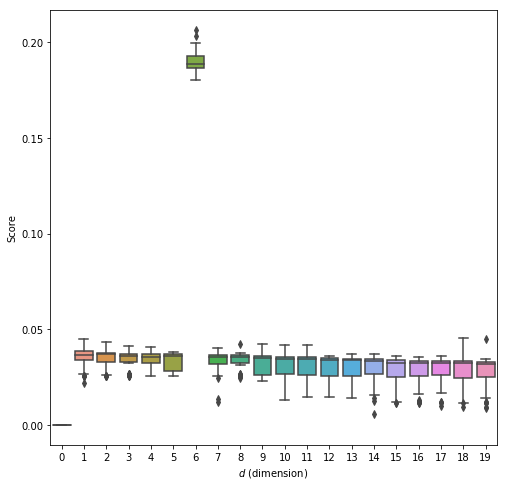

In [5]:
#to generate plot for Algorithm 2 (seaborn)
df = pd.DataFrame(data=Gap)
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.boxplot(ax=ax, data=df)
ax.set(xlabel='$d$ (dimension)',ylabel='Score')
plt.show()